# Boosting for Classification on UCI Breast Cancer dataset


Here, we test the performance of different boosting algorithms on the UCI breast cancer dataset. The three algorithms compared here are:
- Adaboost
- Logitboost
- Frank-Wolfe boost
#### Base Classifiers used:
All these algorithms use the same base classifier; DecisionTreeClassifier for Adaboost & FWBoost and DecisionTreeRegressor for LogitBoost.Restricting the depth of the tree allows us to control the "strength" of each of the classifiers used in the ensemble.
#### Loss functions & descent algorithms:
- Adaboost: The first & most widely used algorithm for boosting classification ensembles. In each iteration, the weak learners try to minimize the loss function $L = e^{-y_{i}f(x_{i})}$. As shown in^{[1]}, Adaboost does a simple gradient descent.
- Logitboost: An extension of Adaboost, which uses logistic regression techniques on the data. weak learners are chosen to minimize the (weighted least-squares) error of ${f_{t}(x)}$ with respect to
${z_{t}={\frac {y^{*}-p_{t}(x)}{2p_{t}(x)(1-p_{t}(x))}}}$.
where ${z_{t}}$ is the Newton–Raphson approximation of the minimizer of the log-likelihood error at stage ${t}$, and the weak learner ${f_{t}}$ is chosen as the learner that best approximates ${z_{t}}$ by weighted least squares.
- Frank-Wolfe boost: Works like Adaboost, but uses the Frank-Wolfe algorithm to perform each gradient descent step.
#### Metrics used for comparison:
In this project, we compare our algorithms on the following metrics: 
- Test & training error w.r.t. the number of iterations.
- Test & training error w.r.t. the time taken by the algorithm.
- Overfitting behaviour w.r.t. the complexity of the base classifier.
- Robustness (simulated by adding randomly sampled N(0,1) error to the label.
#### Dataset description:
The UCI Breast Cancer dataset has 569 data points, each with 30 features, a patient ID, and a diagnosis (benign/malignent). We divided the dataset into two parts - the first 170 datapoints constitute the test set, and the remaining constitute the training set. We did not use any cross validation techniques for this project.

Text throughout the remainder of this notebook explains our methodology and explains our observations.

Reference: 

[1]Friedman, J. H., Hastie, T. and Tibshirani, R.. 2000. Additive logistic regression: a statistical view of boosting. Ann. Stat. 28: 337–407.

[2]Mason L., Baxter J., Bartlett P., Frean M., Boosting algorithms as gradient descent, 12th International Conference on Neural Information Processing Systems, 1999


[2]Wang C.,Wang L., et al., Functional Frank-Wolfe Boosting for General Loss Functions, arXiv:1510.02558(stat.ML), 2015



In [2]:
import sys
sys.path.append("/Users/vasanti/miniconda2/lib/python2.7/site-packages")
%matplotlib inline
import numpy as np
from os import getcwd
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
from numpy.linalg import inv
import random
import math
import csv
from time import clock
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [3]:
Y = np.zeros((569,1))-1
X = np.zeros((569,30))
data = []
scores = []
count = 0
i = 0 

with open(getcwd()+'//wdbc.data') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if row[1] == 'M':
            Y [ count,0 ] = 1 
        for x in xrange(30): 
            X[count,x] = row[x+2]
        count = count + 1

X_test = X[0:170,:]
Y_test = Y[0:170,0]
X_train = X[170:569,:]
Y_train = Y[170:569,0]


In [4]:
"""  PRINT ERROR RATE ======================================="""
def print_error_rate(err):
    print 'Error rate: Training: %.4f - Test: %.4f' % err

In [5]:
"""  GET ERROR RATE ========================================="""
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

In [6]:
""" GENERIC CLASSIFIER ====================================="""
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train),get_error_rate(pred_test, Y_test)
    

In [7]:
""" FRANK WOLFE IMPLEMENTATION ================================================="""
def fwboost_clf(Y_train, X_train, Y_test, X_test, M, clf, add_noise = 0):
    n_train, n_test = len(X_train), len(X_test)
    
    pred_train = np.zeros(n_train)
    pred_test = np.zeros(n_test)
    err_train = np.zeros(M)
    err_test = np.zeros(M)
    time_taken = np.zeros(M)
    w = np.ones(n_train)/n_train
    C = 1
    
    if add_noise == 1:
        Y_train_noise = np.sign(Y_train + rn.randn(n_train))
        
    start_time = clock()
    for i in range(M):
        # Fit a classifier with the specific weights
        if add_noise == 1:
            clf.fit(X_train, Y_train_noise, sample_weight = w)
        else:
            clf.fit(X_train,Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        gamma = 2/(i+0.1)
        w = np.power(w,1-gamma)*np.exp(-gamma*C*Y_train*pred_train_i)
        w = w/sum(w)
        
        #Add to prediction
        pred_train = (1-gamma)*pred_train + gamma*C*pred_train_i
        pred_test = (1-gamma)*pred_test + gamma*C*pred_test_i
        
        # Update error series.
        err_train[i] =  get_error_rate(np.sign(pred_train),Y_train)
        err_test[i] = get_error_rate(np.sign(pred_test),Y_test)
        
        # Update time series.
        time_taken[i] = clock() - start_time

    return pred_train,pred_test,err_train,err_test,time_taken

In [8]:
#Logit boost algorithm
def logitboost_clf(Y_train, X_train, Y_test, X_test, M, clf, add_noise = 0):
    n_train, n_test = len(X_train), len(X_test)
    
    if add_noise == 1:
        Y_train_noise = np.sign(Y_train + rn.randn(n_train))
        Y_train_1 = (Y_train_noise+1)/2
    else:
        Y_train_1 = (Y_train+1)/2
    
    pred_train = np.zeros(n_train)
    pred_test = np.zeros(n_test)

    err_train = np.zeros(M)
    err_test = np.zeros(M)
    time_taken = np.zeros(M)

    p = np.ones(n_train) / 2
    
    start_time = clock()
    for i in range(M):
        w = p*(1-p)
        # Fit a classifier with the specific weights
        z = (Y_train_1 - p)/w
        
        clf.fit(X_train, z , sample_weight = w)
        pred_train_x = clf.predict(X_train)
        pred_test_x = clf.predict(X_test)
        
        
        # Add to prediction
        pred_train = pred_train + (pred_train_x/2)
        pred_test = pred_test + (pred_test_x/2)
        
        p = 1 / (1 + np.exp(-pred_train))
        
        p = p - (p > 0.9999)*0.001    
        
        err_train[i] =  get_error_rate(np.sign(pred_train),Y_train)
        err_test[i] = get_error_rate(np.sign(pred_test),Y_test)
        time_taken[i] = clock() - start_time
        
    return pred_train,pred_test,err_train,err_test,time_taken

In [9]:
""" ADABOOST IMPLEMENTATION ================================================="""
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf, add_noise = 0):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    pred_train = np.zeros(n_train)
    
    pred_test = np.zeros(n_test)
    err_train = np.zeros(M)
    err_test = np.zeros(M)
    time_taken = np.zeros(M)
    #pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    if add_noise == 1:
        Y_train_noise = np.sign(Y_train + rn.randn(n_train))
    
    start_time = clock()
    for i in range(M):
        # Fit a classifier with the specific weights
        if add_noise == 1:
            clf.fit(X_train, Y_train_noise, sample_weight = w)
        else:
            clf.fit(X_train,Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        # Indicator function
        hit = (pred_train_i == Y_train)
        err_m_1 = 1 - np.dot(w,hit)
        if(err_m_1 == 0):
            err_m_1 = 0.1
        if(err_m_1 == 1):
            err_m_1 = 0.9
        alpha_m = np.log(1-err_m_1)-np.log(err_m_1)
    
        # Equivalent with 1/-1 to update weights
        y_h = 2 * hit - 1;
        
        # New weights
        w = np.multiply(w, np.exp(-0.5*alpha_m*y_h))
        w = w / sum(w)
        
        # Add to prediction
        pred_train = pred_train + 0.5*alpha_m*pred_train_i
        pred_test = pred_test + 0.5*alpha_m*pred_test_i
        
        # Update error series.
        err_train[i] =  get_error_rate(np.sign(pred_train),Y_train)
        err_test[i] = get_error_rate(np.sign(pred_test),Y_test)
        # Update time series.
        time_taken[i] = clock() - start_time
        #Stop training if training error of the classifier is 0.
        if get_error_rate(np.sign(pred_train),Y_train) == 0:
            break
        
    err_train[i:M] = err_train[i]
    err_test[i:M] = err_test[i]
    time_taken[i:M] = clock()-start_time

    return pred_train,pred_test,err_train,err_test,time_taken

In [10]:
""" PLOT FUNCTION ==========================================================="""
#xseries is a numpy array, passed as a parameter when we are plotting w.r.t.
#anything other than number of iterations.
def plot_1_clf(er_train, er_test, xlabel, ylabel, name, xseries=[]):
    if len(xseries) != 0:
        plt.plot(xseries,er_train)
        plt.plot(xseries,er_test)
    else:
        plt.plot(er_train)
        plt.plot(er_test)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['Training data','Test data'])
    plt.title(ylabel + ' for ' + name)
    plt.show()

In [11]:
""" PLOT FUNCTION ==========================================================="""
#names is a list of strings providing the legend.
def plot_clf_series(series,names,xlabel,ylabel,xseries = []):
    M = series.shape[1];
    for i in range(M):
        if len(xseries) != 0:
            plt.plot(xseries[:,i],series[:,i])
        else:
            plt.plot(series[:,i])
    plt.legend(names)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    

In [12]:
""" PLOT FUNCTION ==========================================================="""
def plot_1_noise(er_train0, er_train1, xlabel, ylabel, name):
    plt.plot(er_train0)
    plt.plot(er_train1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['With noise','Without noise'])
    plt.title(ylabel + ' for ' + name)
    plt.show()

In [13]:
# Fix the number of algorithms that are being implemented.
NUM_ALGO = 3
#List the algorithm names.
names = ['Adaboost','LogitBoost','FWBoost']
# Set the base classifier.
clf_base = DecisionTreeClassifier(max_depth = 1)

Below, we run each of the algorithms for 300 iterations. All the algorithms use a decision stump as the base classifier. This enables us to judge the fitting accuracy and the overfitting behaviour of our algorithms.

In [14]:
# Seeing the effect of changing the number of iterations. 
#Set number of iterations.
N = 300
#Initialize the arrays.
er_train_0 = np.zeros([N,NUM_ALGO])
er_test_0 = np.zeros([N,NUM_ALGO])
time_taken_0 = np.zeros([N,NUM_ALGO])
#Iterate over the algorithms.
pred_train,pred_test,er_train_0[:,0],er_test_0[:,0],time_taken_0[:,0] = adaboost_clf(Y_train, X_train, Y_test, X_test, N, clf_base)
#LogitBoost
clf_base = DecisionTreeRegressor(max_depth = 1)
pred_train,pred_test,er_train_0[:,1],er_test_0[:,1],time_taken_0[:,1] = logitboost_clf(Y_train, X_train, Y_test, X_test, N, clf_base)
clf_base = DecisionTreeClassifier(max_depth = 1)
pred_train,pred_test,er_train_0[:,2],er_test_0[:,2],time_taken_0[:,2] = fwboost_clf(Y_train, X_train, Y_test, X_test, N, clf_base)



In the two cells below, we plot the Misclassification rate for each of our algorithms. Specifically, we notice the following things.
- As expected, Adaboost is very resistant to overfitting w.r.t. the number of iterations. Since the other two algorithms are derivatives of Adaboost, this resistance extends to them as well.
- We also notice that Adaboost reaches 0 training loss very quickly (in ~20 iterations), and Logitboost takes significantly longer (~100 iterations). Meanwhile, FWBoot does not reach a training error of exactly zero, but instead converges to a small value.
- The final training & test losses for LogitBoost and Adaboost are very similar, and much lower than the final loss for FWBoost.

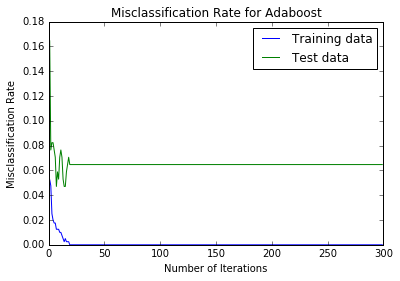

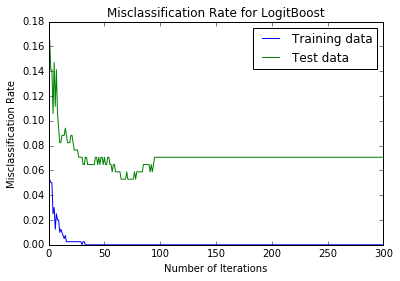

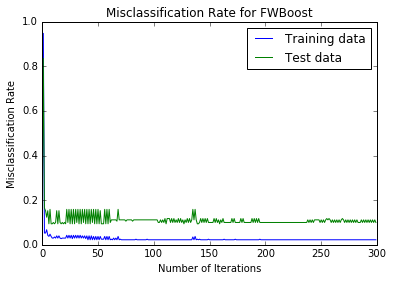

In [15]:
#Plot training and test errors for each algorithm.
for i in range(NUM_ALGO):
    plot_1_clf(er_train_0[:,i], er_test_0[:,i], 'Number of Iterations', 'Misclassification Rate',names[i])

In the plots below, we see that AdaBoost converges much more quickly than LogitBoost and FWBoost, which is exactly what we expect (since all the algorithms do a similar amount of work per iteration, and AdaBoost takes a much lower number of iterations to converge as compared to the other two.

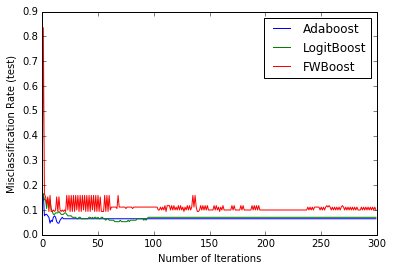

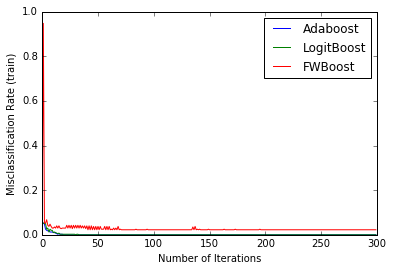

In [16]:
#Compare test error rate vs. number of iterations across algorithms.
plot_clf_series(er_test_0,names,'Number of Iterations','Misclassification Rate (test)')
#Compare test error rate vs. number of iterations across algorithms.
plot_clf_series(er_train_0,names,'Number of Iterations','Misclassification Rate (train)')

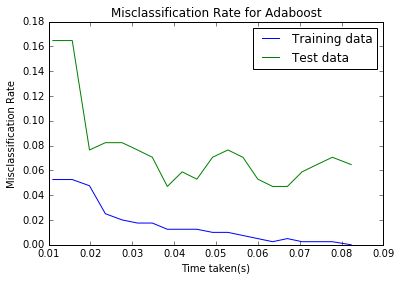

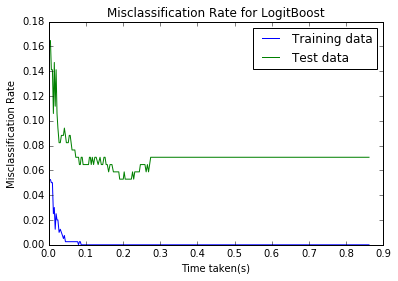

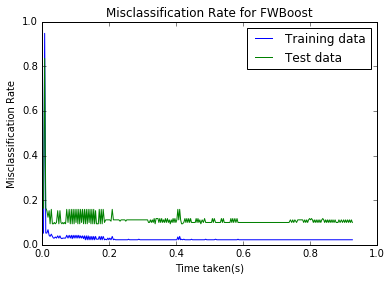

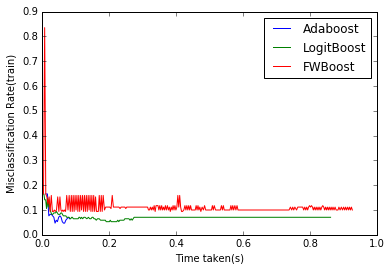

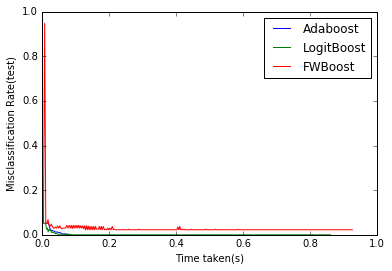

In [17]:
#Do the same w.r.t. the time taken (instead of number of iterations).
for i in range(NUM_ALGO):
    plot_1_clf(er_train_0[:,i], er_test_0[:,i], 'Time taken(s)', 'Misclassification Rate',names[i],time_taken_0[:,i])
plot_clf_series(er_test_0,names,'Time taken(s)','Misclassification Rate(train)',time_taken_0)

#Compare test error rate vs. number of iterations across algorithms.
plot_clf_series(er_train_0,names,'Time taken(s)','Misclassification Rate(test)',time_taken_0)

Here, we simulate the effect of another kind of overfitting, by changing the strength of the base classifier, and keeping the number of iterations the same. All the algorithms are run for 50 iterations. We see that all of our algorithms are very susceptible to overfitting wrt base classifier complexity. All of the algorithms reach the best test error when we use a base classifier of depth 2-3. Using a deeper base classifier increases the test error, while reducing the training error, hence causing overfitting.

In [22]:
#Seeing the effect of changing the depth of the base classifier.
#Set number of iterations.
N = 50
#Set max depth of classifier.
M = 10
#Initialize the arrays.
er_train_1 = np.zeros((M,NUM_ALGO))
er_test_1 = np.zeros((M,NUM_ALGO))
#Iterate over the algorithms.
#Just Adaboost is implemented at the moment.
for i in range(M):
    clf_base = DecisionTreeClassifier(max_depth = i+1)
    pred_train,pred_test,er_train,er_test,time_taken = adaboost_clf(Y_train, X_train, Y_test, X_test, N, clf_base)
    er_train_1[i,0] = er_train[N-1]
    er_test_1[i,0] = er_test[N-1]
    pred_train,pred_test,er_train,er_test,time_taken = fwboost_clf(Y_train, X_train, Y_test, X_test, N, clf_base)
    er_train_1[i,2] = er_train[N-1]
    er_test_1[i,2] = er_test[N-1]
    clf_base = DecisionTreeRegressor(max_depth = i+1)
    pred_train,pred_test,er_train,er_test,time_taken = logitboost_clf(Y_train, X_train, Y_test, X_test, N, clf_base)
    er_train_1[i,1] = er_train[N-1]
    er_test_1[i,1] = er_test[N-1]

/Users/vasanti/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in log


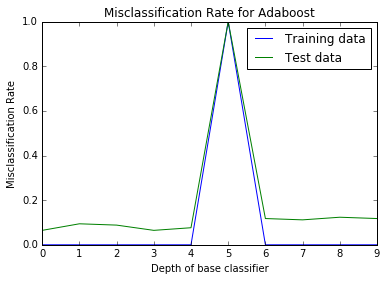

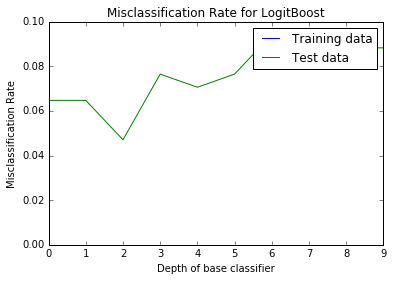

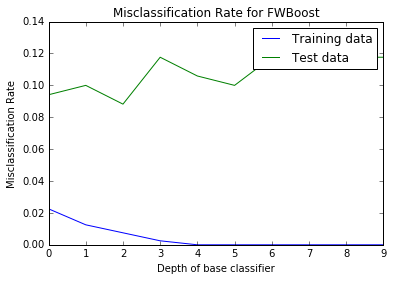

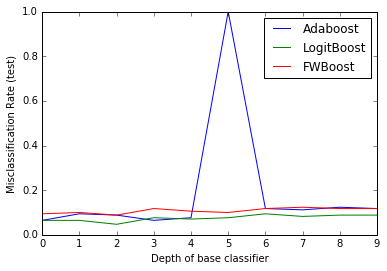

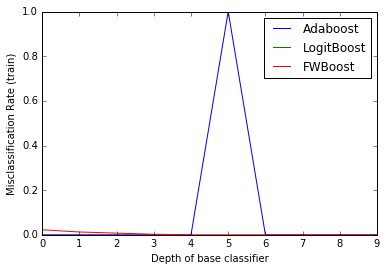

In [23]:
#Do the same w.r.t. the time taken (instead of number of iterations).
for i in range(NUM_ALGO):
    plot_1_clf(er_train_1[:,i], er_test_1[:,i], 'Depth of base classifier', 'Misclassification Rate',names[i])
#Plot training and test error vs. base classifier depth across algorithms.
plot_clf_series(er_test_1,names,'Depth of base classifier','Misclassification Rate (test)')
#Compare test error rate vs. base classifier depth across algorithms.
plot_clf_series(er_train_1,names,'Depth of base classifier','Misclassification Rate (train)')

Here, we simulate the robustness of our algorithms by adding N(0,1) error to the true label (while training) and comparing the results against the true label (while calculating the error). From the graphs below, we notice the following:
- As expected, the training and test errors increase for all of the algorithms upon corrupting the labels during training.
- Both Adaboost and LogitBoost work poorly when error is added to the data. While AdaBoost maintains a constant performance throughout the iterations, LogitBoost performance becomes significantly worse as the number of iterations increases.
- FWBoost is much more resistant to noise, and its misclassification rate is only slightly worse than its performance without any error.
- Due to the above, FWBoost (which performs the worst without any added error), gives the best test & training error among all the algorithms once the label values are corrupted.

In [24]:
N = 300
#Seeing the effect of adding N(0,1) gaussian noise to the label.
er_train_n = np.zeros([N,NUM_ALGO])
er_test_n = np.zeros([N,NUM_ALGO])
time_taken_n = np.zeros([N,NUM_ALGO])
clf_base = DecisionTreeClassifier(max_depth = 1)
pred_train,pred_test,er_train_n[:,0],er_test_n[:,0],time_taken_n[:,0] = adaboost_clf(Y_train, X_train, Y_test, X_test, N, clf_base,1)
clf_base = DecisionTreeRegressor(max_depth = 1)
pred_train,pred_test,er_train_n[:,1],er_test_n[:,1],time_taken_n[:,1] = logitboost_clf(Y_train, X_train, Y_test, X_test, N, clf_base,1)
clf_base = DecisionTreeClassifier(max_depth = 1)
pred_train,pred_test,er_train_n[:,2],er_test_n[:,2],time_taken_n[:,2] = fwboost_clf(Y_train, X_train, Y_test, X_test, N, clf_base,1)



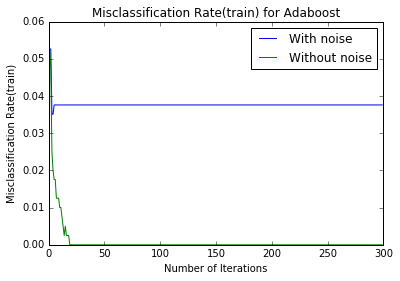

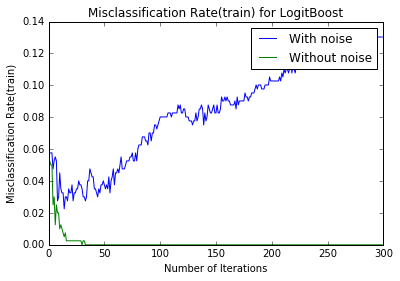

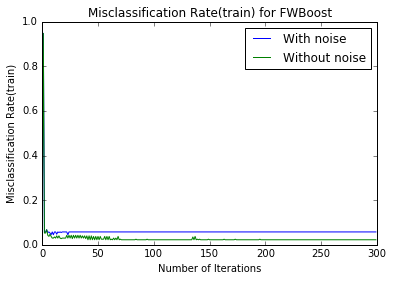

In [25]:
#Plot training error for each algorithm.
for i in range(NUM_ALGO):
    plot_1_noise(er_train_n[:,i], er_train_0[:,i], 'Number of Iterations', 'Misclassification Rate(train)',names[i])

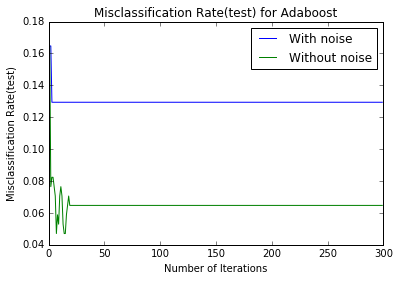

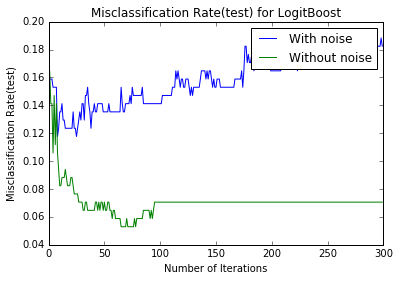

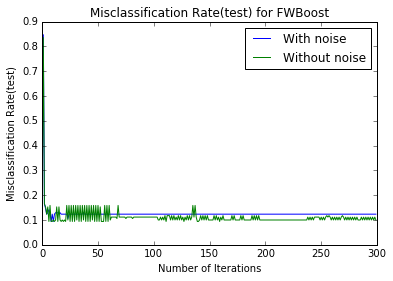

In [27]:
#Plot test error for each algorithm.
for i in range(NUM_ALGO):
    plot_1_noise(er_test_n[:,i], er_test_0[:,i], 'Number of Iterations', 'Misclassification Rate(test)',names[i])

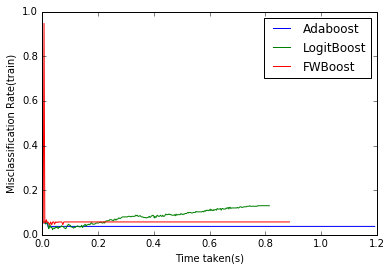

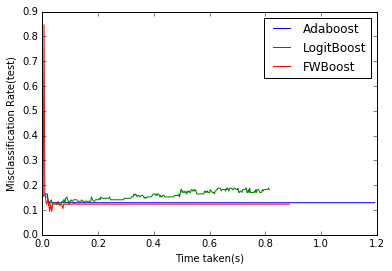

In [28]:
#Compare error rate vs. number of iterations across algorithms.
plot_clf_series(er_train_n,names,'Time taken(s)','Misclassification Rate(train)',time_taken_n)
plot_clf_series(er_test_n,names,'Time taken(s)','Misclassification Rate(test)',time_taken_n)